<a href="https://colab.research.google.com/github/Gialbo/COVID-Chest-X-Rays-Deep-Learning-analysis/blob/main/experiments/InceptionGenerativeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Gialbo/COVID-Chest-X-Rays-Deep-Learning-analysis/blob/main/experiments/cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation using the images generated from GAN models

### Import libraries and data

In [ ]:
# IMPORT AND MOUNT DRIVE
import tensorflow as tf
import numpy as np
import os
import os.path
import sys
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Recall, Precision
from skimage.transform import resize

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CLONE GITHUB REPOSITORY
!rm -r "COVID-Chest-X-Rays-Deep-Learning-analysis"
!git clone https://github.com/Gialbo/COVID-Chest-X-Rays-Deep-Learning-analysis.git

rm: cannot remove 'COVID-Chest-X-Rays-Deep-Learning-analysis': No such file or directory
Cloning into 'COVID-Chest-X-Rays-Deep-Learning-analysis'...
remote: Enumerating objects: 1446, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 1446 (delta 49), reused 18 (delta 17), pack-reused 1390
Receiving objects: 100% (1446/1446), 138.85 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (759/759), done.


In [ ]:
# LOAD DIRECTORIES
sys.path.append('COVID-Chest-X-Rays-Deep-Learning-analysis/models')
sys.path.append('COVID-Chest-X-Rays-Deep-Learning-analysis/tools')

from inceptionNet import inceptionNet
from inceptionNetMCD import inceptionNetMCD
from XRaysDataset import XRaysDataset
from plotter import *

In [ ]:
# LOAD TRAINING DATA

batch_size = 64

train_dir = '/content/drive/MyDrive/BIOINF/covid-project/dataset/train'
dataset = XRaysDataset(batch_size=batch_size, dir=train_dir, img_height=224, img_width=224, isInceptionNet=True)
train_ds, val_ds = dataset.load(train_val_split=True)

test_dir = '/content/drive/MyDrive/BIOINF/covid-project/dataset/test'
dataset = XRaysDataset(batch_size=batch_size, dir=test_dir, img_height=224, img_width=224, isInceptionNet=True)
test_ds, test_size = dataset.load(separate_classes=False)

Number of batches for the train dataset: 44
Number of batches for the validation dataset: 11
Dataset size  383
Number of batches for the dataset: 6


### The classification model

In [ ]:
def get_classification_model(mod_type):
  if mod_type == "inception":
    return inceptionNet() 
  if mod_type == "inception_mcd":
    return inceptionNetMCD() 

### Training loop

In [ ]:
def train(generative_model, train_ds, val_ds,
          n_trials=5, batch_size=batch_size, half_data=True, patience=20, max_epochs=100,
          checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/",
          mod_type="inception"):
  history = {}

  for i in range(n_trials):
    history[str(i+1)] = History()


    print("--------------- TRIAL " + str(i+1) + " --------------- ")
    classification_model = get_classification_model(mod_type)
    model = GenerativeClassification(generative_model=generative_model, classification_model=classification_model, n_epochs=max_epochs,
                                     batch_size=batch_size, half_data=True, patience=20,
                                     checkpoint_dir=os.path.join(checkpoint_dir, str(i+1)))
    history[str(i+1)].history = model.train_model(train_ds=train_ds, val_ds=val_ds, steps_per_epoch=54)

  return history

### Evaluation Loop

In [ ]:
def evaluate_model(checkpoint_dir, test_ds, mod_type="inception", n_trials=5):
  tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
  results = {}

  for i in range(n_trials):
    results[str(i+1)] = []

    print("--------------- TRIAL " + str(i+1) + " --------------- ")

    weights_path = os.path.join(checkpoint_dir, str(i+1) ,'best')
    model = inceptionNet()
    # LOAD A CHECKPOINT FROM DRIVE

    classification_model = get_classification_model(mod_type)
    checkpoint = tf.train.Checkpoint(model=classification_model)

    best = tf.train.latest_checkpoint(weights_path)
    print(best)
    checkpoint.restore(best)
    results[str(i+1)] = classification_model.evaluate(test_ds, verbose=2)

  # SHOW CLASSIFICATION REPORT
  loss = np.zeros(n_trials)
  accuracy = np.zeros(n_trials)
  recall_covid = np.zeros(n_trials)
  recall_normal = np.zeros(n_trials)
  recall_viral_pneumonia = np.zeros(n_trials)
  precision_covid = np.zeros(n_trials)
  precision_normal = np.zeros(n_trials)
  precision_viral_preumonia = np.zeros(n_trials)

  for i in range(n_trials):
    loss[i] = results[str(i+1)][0]
    accuracy[i] = results[str(i+1)][1]
    recall_covid[i] = results[str(i+1)][2]
    recall_normal[i] = results[str(i+1)][3]
    recall_viral_pneumonia[i] = results[str(i+1)][4]
    precision_covid[i] = results[str(i+1)][5]
    precision_normal[i] = results[str(i+1)][6]
    precision_viral_preumonia[i] = results[str(i+1)][7]

  print("--- LOSS ---")
  print("Mean ", np.mean(loss))
  print("Standard Deviation ", np.std(loss))
  print("--- ACCURACY ---")
  print("Mean ", np.mean(accuracy))
  print("Standard Deviation ", np.std(accuracy))

  print("--- RECALL, COVID 19 ---")
  print("Mean ", np.mean(recall_covid))
  print("Standard Deviation ", np.std(recall_covid))
  print("--- RECALL, NORMAL ---")
  print("Mean ", np.mean(recall_normal))
  print("Standard Deviation ", np.std(recall_normal))
  print("--- RECALL, VIRAL PNEUMONIA ---")
  print("Mean ", np.mean(recall_viral_pneumonia))
  print("Standard Deviation ", np.std(recall_viral_pneumonia))

  print("--- PRECISION, COVID 19 ---")
  print("Mean ", np.mean(precision_covid))
  print("Standard Deviation ", np.std(precision_covid))
  print("--- PRECISION, NORMAL ---")
  print("Mean ", np.mean(precision_normal))
  print("Standard Deviation ", np.std(precision_normal))
  print("--- PRECISION, VIRAL PNEUMONIA ---")
  print("Mean ", np.mean(precision_viral_preumonia))
  print("Standard Deviation ", np.std(precision_viral_preumonia))

  return results

### Utility methods

In [ ]:
# Placeholder needed to be compatible with tensrflow format
class History():
  def __init__(self):
    self.history = []

def history_to_dict(history):
  for k in history.keys():
    history[k] = history[k].history
  return history

def history_to_obj(history):
  for k in history.keys():
    h = History()
    h.history = history[k]
    history[k] = h
  return history      

## cGAN Experiments

### No Uncertainty model

#### Loading the generative model




In [ ]:
from cGAN import cGAN
from GenerativeClassification import GenerativeClassification

In [ ]:
# LOAD A CHECKPOINT FROM DRIVE
checkpoint_dir = '/content/drive/MyDrive/BIOINF/checkpoints_GAN/cGAN' #

generative_model = cGAN(batch_size=batch_size, use_residual=True) #
checkpoint = tf.train.Checkpoint(generator_optimizer=generative_model.generator_optimizer,
                                    discriminator_optimizer=generative_model.discriminator_optimizer,
                                    model=generative_model.model)

latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
checkpoint.restore(latest)

/content/drive/MyDrive/BIOINF/checkpoints_GAN/cGAN/ckpt-11


#### Testing generation capabilities

In [ ]:
# noise used during training in order to evaluate how the network is learning
benchmarkNoise = tf.random.normal([512, generative_model.latent_size])
benchmarkLabels = np.random.randint(0, generative_model.n_classes, 512)

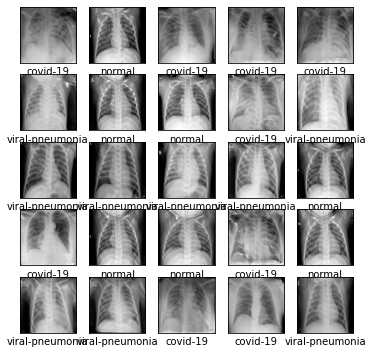

In [ ]:
generative_model.plot_fake_figures(generative_model.generator.predict([benchmarkNoise, benchmarkLabels]), benchmarkLabels, 5, 0)

#### Half data training (early stopping)

In [ ]:
history = train(generative_model, train_ds, val_ds,
                n_trials=5, batch_size=batch_size, half_data=True, patience=10,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data")

In [ ]:
history = history_to_dict(history)
save_history(history, "/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/cGAN_half_data")

#### Half Data Training (1 run without early stopping)

In [ ]:
plotting_history = train(generative_model, train_ds, val_ds,
                n_trials=1, batch_size=batch_size, half_data=True, patience=50, max_epochs=50,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/plotting_run")

In [ ]:
plotting_history = history_to_dict(plotting_history)
save_history(plotting_history,"/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/plotting_history")

#### MCD Training

In [ ]:
# Testing of MCD nets is in the InceptionNetMCD notebook
# If it doesn't work the first time, re execute the cell three times and it works
mcd_history = train(generative_model, train_ds, val_ds,
                n_trials=1, batch_size=batch_size, half_data=True, patience=10, mod_type="inception_mcd",
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/mcd_run")

#### Half data testing

In [ ]:
results = evaluate_model("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/", test_ds)

--------------- TRIAL 1 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/1/best/ckpt-1
6/6 - 133s - loss: 0.1683 - accuracy: 0.9582 - recall_21: 0.9913 - recall_22: 0.9478 - recall_23: 0.9403 - precision_21: 1.0000 - precision_22: 0.9407 - precision_23: 0.9403
--------------- TRIAL 2 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/2/best/ckpt-1
6/6 - 4s - loss: 0.2780 - accuracy: 0.9478 - recall_27: 0.9565 - recall_28: 0.9030 - recall_29: 0.9851 - precision_27: 1.0000 - precision_28: 0.9837 - precision_29: 0.8800
--------------- TRIAL 3 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/3/best/ckpt-1
6/6 - 3s - loss: 0.1582 - accuracy: 0.9608 - recall_33: 0.9652 - recall_34: 0.9403 - recall_35: 0.9776 - precision_33: 1.0000 - precision_34: 0.9767 - precision_35: 0.9161
--------------- TRIAL 4 --------------- 
/content/drive/MyDrive/BIOINF/che

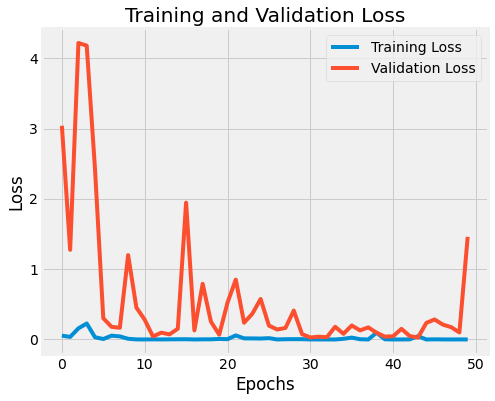

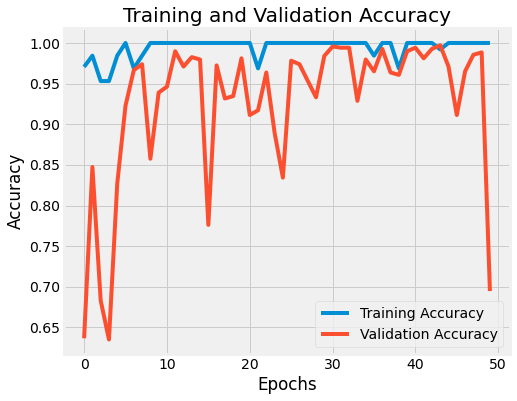

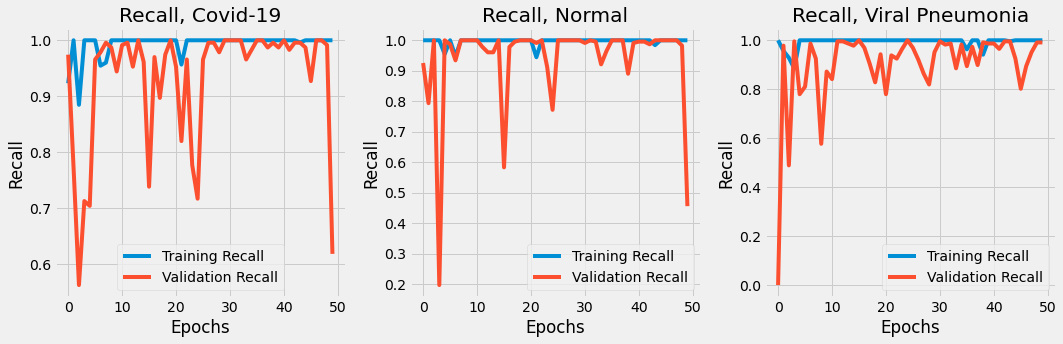

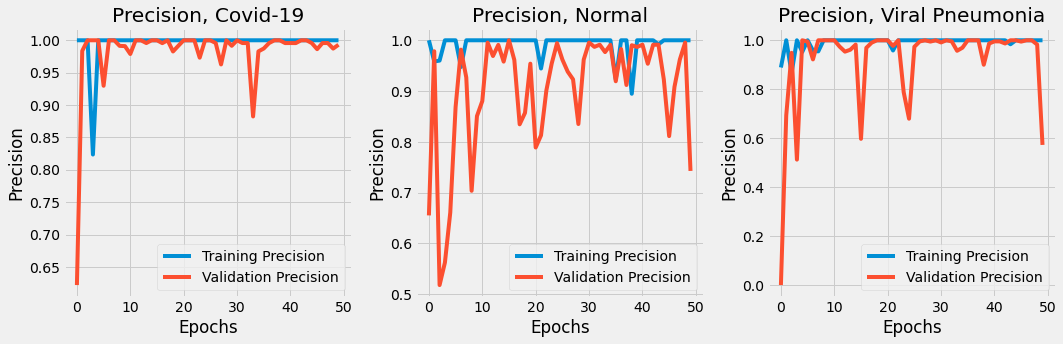

In [ ]:
with open("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/plotting_history.json", 'r') as fs:
  plotting_history = json.load(fs)
plotting_history = history_to_obj(plotting_history)
plot_classification_report(plotting_history, selected_run="1")

### Max Uncertainty

#### Loading the generative model




In [ ]:
from cGAN_Uncertainty import cGANUnc
from GenerativeClassification import GenerativeClassification

In [ ]:
# LOAD A CHECKPOINT FROM DRIVE
checkpoint_dir = '/content/drive/MyDrive/BIOINF/checkpoints_GAN/cGAN-unc-max_OLD' #

generative_model = cGANUnc(batch_size=batch_size, use_residual=True) #
checkpoint = tf.train.Checkpoint(generator_optimizer=generative_model.generator_optimizer,
                                    discriminator_optimizer=generative_model.discriminator_optimizer,
                                    model=generative_model.model)

latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
checkpoint.restore(latest)

/content/drive/MyDrive/BIOINF/checkpoints_GAN/cGAN-unc-max_OLD/ckpt-6


#### Testing generation capabilities

In [ ]:
# noise used during training in order to evaluate how the network is learning
benchmarkNoise = tf.random.normal([512, generative_model.latent_size])
benchmarkLabels = np.random.randint(0, generative_model.n_classes, 512)

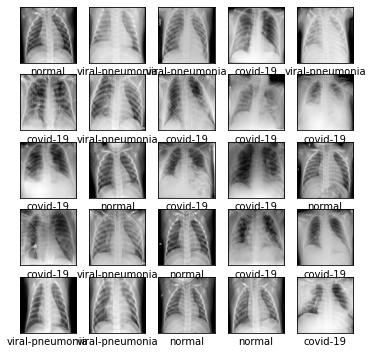

In [ ]:
generative_model.plot_fake_figures(generative_model.generator.predict([benchmarkNoise, benchmarkLabels]), benchmarkLabels, 5, 0)

#### Half data training (early stopping)

In [ ]:
history = train(generative_model, train_ds, val_ds,
                n_trials=5, batch_size=batch_size, half_data=True, patience=10,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data")

In [ ]:
history = history_to_dict(history)
save_history(history, "/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/cGAN_max_unc_half_data")

#### Half Data Training (1 run without early stopping)

In [ ]:
plotting_history = train(generative_model, train_ds, val_ds,
                n_trials=1, batch_size=batch_size, half_data=True, patience=50, max_epochs=50,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/plotting_run")

In [ ]:
plotting_history = history_to_dict(plotting_history)
save_history(plotting_history,"/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/plotting_history")

#### MCD Training

In [ ]:
# Testing of MCD nets is in the InceptionNetMCD notebook
# If it doesn't work the first time, re execute the cell three times and it works
mcd_history = train(generative_model, train_ds, val_ds,
                n_trials=1, batch_size=batch_size, half_data=True, patience=10, mod_type="inception_mcd",
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/mcd_run")

#### Half data testing

In [ ]:
results = evaluate_model("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/", test_ds)

--------------- TRIAL 1 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/1/best/ckpt-1
6/6 - 54s - loss: 0.1284 - accuracy: 0.9713 - recall_21: 0.9913 - recall_22: 0.9328 - recall_23: 0.9851 - precision_21: 1.0000 - precision_22: 0.9843 - precision_23: 0.9362
--------------- TRIAL 2 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/2/best/ckpt-1
6/6 - 4s - loss: 0.1123 - accuracy: 0.9608 - recall_27: 0.9826 - recall_28: 0.9403 - recall_29: 0.9627 - precision_27: 1.0000 - precision_28: 0.9618 - precision_29: 0.9281
--------------- TRIAL 3 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/3/best/ckpt-1
6/6 - 3s - loss: 0.2331 - accuracy: 0.9687 - recall_33: 0.9826 - recall_34: 0.9552 - recall_35: 0.9701 - precision_33: 1.0000 - precision_34: 0.9697 - precision_35: 0.9420
--------------- TRIAL 4 --------------- 
/content/d

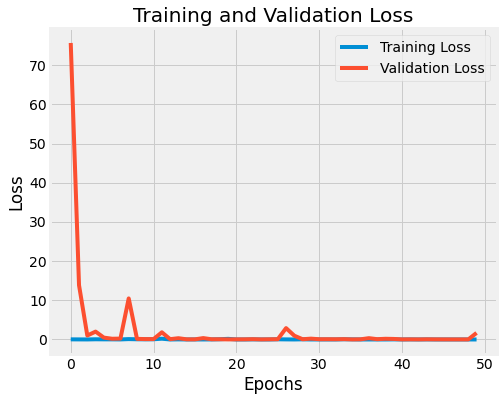

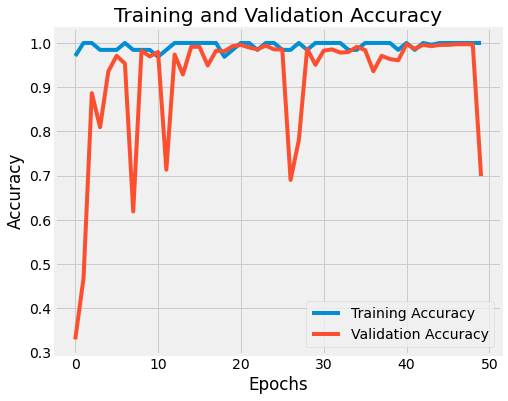

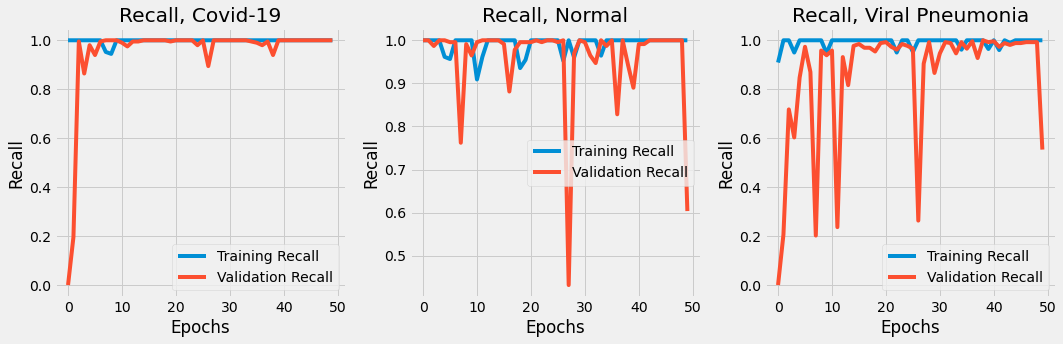

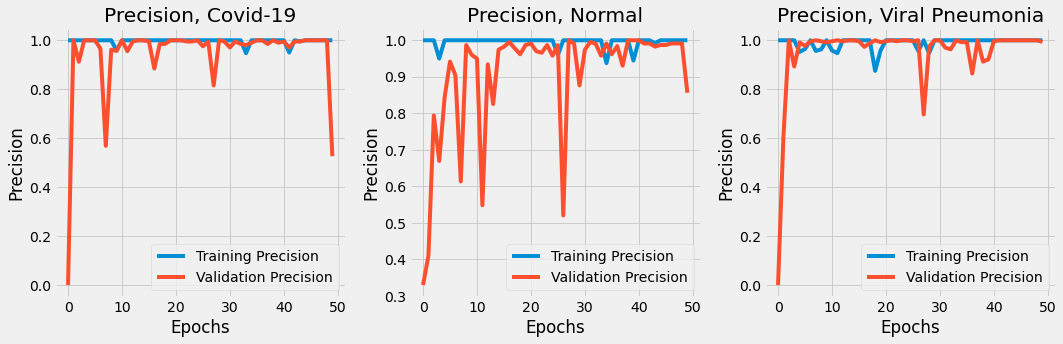

In [ ]:
with open("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/plotting_history.json", 'r') as fs:
  plotting_history = json.load(fs)
plotting_history = history_to_obj(plotting_history)
plot_classification_report(plotting_history, selected_run="1")

### Min Uncertainty

#### Loading the generative model




In [ ]:
from cGAN_Uncertainty import cGANUnc
from GenerativeClassification import GenerativeClassification

In [ ]:
# LOAD A CHECKPOINT FROM DRIVE
checkpoint_dir = '/content/drive/MyDrive/BIOINF/checkpoints_GAN/cGAN_unc_min' #

generative_model = cGANUnc(batch_size=batch_size, use_residual=True) #
checkpoint = tf.train.Checkpoint(generator_optimizer=generative_model.generator_optimizer,
                                    discriminator_optimizer=generative_model.discriminator_optimizer,
                                    model=generative_model.model)

latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
checkpoint.restore(latest)

/content/drive/MyDrive/BIOINF/checkpoints_GAN/cGAN_unc_min/ckpt-11


#### Testing generation capabilities

In [ ]:
# noise used during training in order to evaluate how the network is learning
benchmarkNoise = tf.random.normal([512, generative_model.latent_size])
benchmarkLabels = np.random.randint(0, generative_model.n_classes, 512)

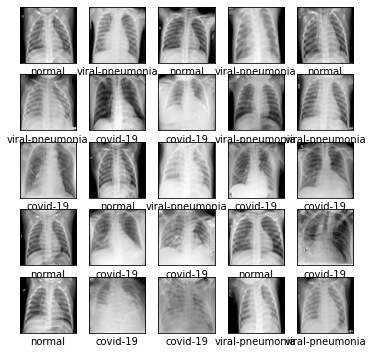

In [ ]:
generative_model.plot_fake_figures(generative_model.generator.predict([benchmarkNoise, benchmarkLabels]), benchmarkLabels, 5, 0)

#### Half data training (early stopping)

In [ ]:
history = train(generative_model, train_ds, val_ds,
                n_trials=5, batch_size=batch_size, half_data=True, patience=10,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data")

In [ ]:
history = history_to_dict(history)
save_history(history, "/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data/cGAN_min_unc_half_data")

#### Half Data Training (1 run without early stopping)

In [ ]:
plotting_history = train(generative_model, train_ds, val_ds,
                n_trials=1, batch_size=batch_size, half_data=True, patience=50, max_epochs=50,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data/plotting_run")

In [ ]:
plotting_history = history_to_dict(plotting_history)
save_history(plotting_history,"/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data/plotting_history")

#### MCD Training

In [ ]:
# Testing of MCD nets is in the InceptionNetMCD notebook
# If it doesn't work the first time, re execute the cell three times and it works
mcd_history = train(generative_model, train_ds, val_ds,
                n_trials=1, batch_size=batch_size, half_data=True, patience=10, mod_type="inception_mcd",
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data/mcd_run")

#### Half data testing

In [ ]:
results = evaluate_model("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data/", test_ds)

--------------- TRIAL 1 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/1/best/ckpt-1
6/6 - 5s - loss: 0.1284 - accuracy: 0.9608 - recall_51: 0.9739 - recall_52: 0.9403 - recall_53: 0.9701 - precision_51: 1.0000 - precision_52: 0.9692 - precision_53: 0.9220
--------------- TRIAL 2 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/2/best/ckpt-1
6/6 - 4s - loss: 0.0773 - accuracy: 0.9713 - recall_57: 0.9739 - recall_58: 0.9776 - recall_59: 0.9627 - precision_57: 1.0000 - precision_58: 0.9632 - precision_59: 0.9556
--------------- TRIAL 3 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/3/best/ckpt-1
6/6 - 3s - loss: 0.1693 - accuracy: 0.9582 - recall_63: 0.9826 - recall_64: 0.9254 - recall_65: 0.9701 - precision_63: 0.9826 - precision_64: 0.9688 - precision_65: 0.9286
--------------- TRIAL 4 --------------- 
/content/dr

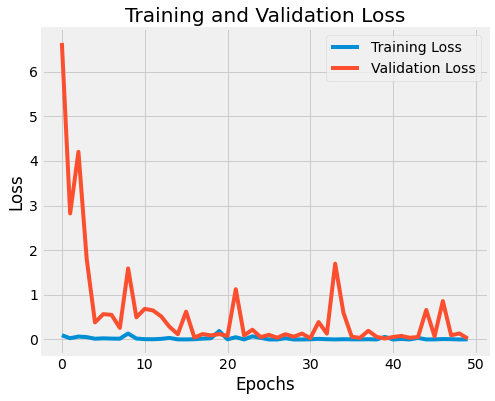

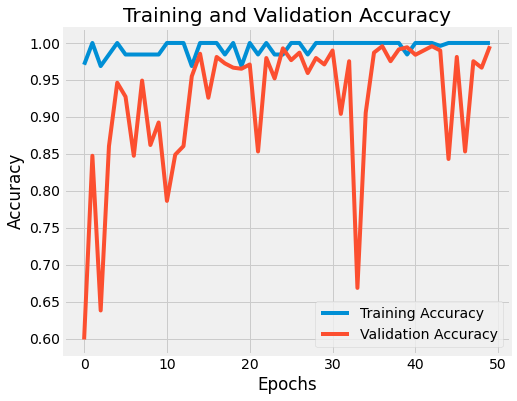

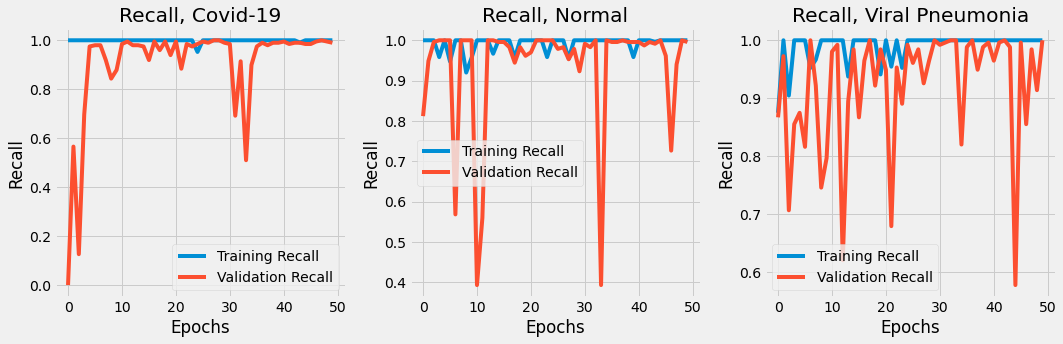

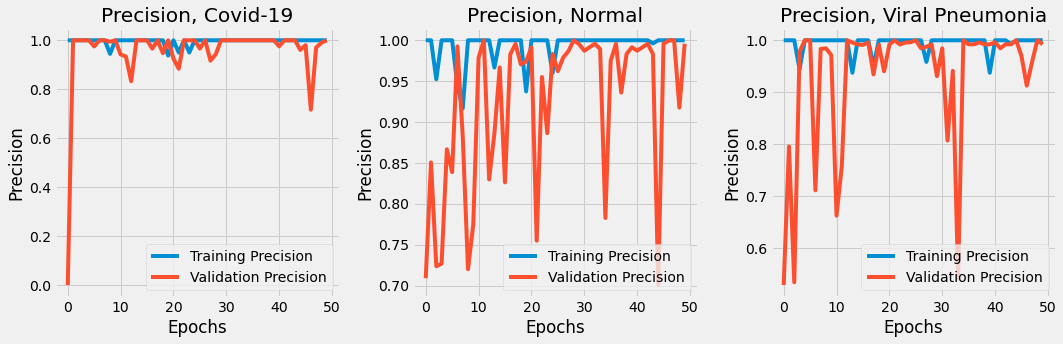

In [ ]:
with open("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data/plotting_history.json", 'r') as fs:
  plotting_history = json.load(fs)
plotting_history = history_to_obj(plotting_history)
plot_classification_report(plotting_history, selected_run="1")

## AC-cGAN Experiments

### No Uncertainty model

#### Loading the generative model




In [ ]:
from ACCGAN import ACCGAN
from GenerativeClassification import GenerativeClassification

In [ ]:
# LOAD A CHECKPOINT FROM DRIVE
checkpoint_dir = '/content/drive/MyDrive/BIOINF/checkpoints_GAN/AC-cGAN' #

generative_model = ACCGAN(batch_size=batch_size, use_residual=True) #
checkpoint = tf.train.Checkpoint(generator_optimizer=generative_model.generator_optimizer,
                                    discriminator_optimizer=generative_model.discriminator_optimizer,
                                    model=generative_model.model)

latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
checkpoint.restore(latest)

/content/drive/MyDrive/BIOINF/checkpoints_GAN/AC-cGAN/ckpt-9


#### Testing generation capabilities

In [ ]:
# noise used during training in order to evaluate how the network is learning
benchmarkNoise = tf.random.normal([512, generative_model.latent_size])
benchmarkLabels = np.random.randint(0, generative_model.n_classes, 512)

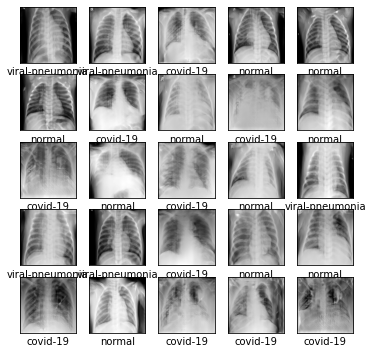

In [ ]:
generative_model.plot_fake_figures(generative_model.generator.predict([benchmarkNoise, benchmarkLabels]), benchmarkLabels, 5, 0)

#### Half data training (early stopping)

In [ ]:
history = train(generative_model, train_ds, val_ds,
                n_trials=5, batch_size=batch_size, half_data=True, patience=10,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data")

In [ ]:
history = history_to_dict(history)
save_history(history, "/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/AC-cGAN_half_data")

#### Half Data Training (1 run without early stopping)

In [ ]:
plotting_history = train(generative_model, train_ds, val_ds,
                n_trials=1, batch_size=batch_size, half_data=True, patience=50, max_epochs=50,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/plotting_run")

In [ ]:
plotting_history = history_to_dict(plotting_history)
save_history(plotting_history,"/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/plotting_history")

#### MCD Training

In [ ]:
# Testing of MCD nets is in the InceptionNetMCD notebook
# If it doesn't work the first time, re execute the cell three times and it works
mcd_history = train(generative_model, train_ds, val_ds,
                n_trials=1, batch_size=batch_size, half_data=True, patience=10, mod_type="inception_mcd",
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/mcd_run")

#### Half data testing

In [ ]:
results = evaluate_model("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/", test_ds)

--------------- TRIAL 1 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/1/best/ckpt-1
6/6 - 4s - loss: 0.1656 - accuracy: 0.9556 - recall_69: 0.9913 - recall_70: 0.9030 - recall_71: 0.9776 - precision_69: 0.9913 - precision_70: 0.9918 - precision_71: 0.9034
--------------- TRIAL 2 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/2/best/ckpt-1
6/6 - 3s - loss: 0.1819 - accuracy: 0.9582 - recall_75: 0.9826 - recall_76: 0.9104 - recall_77: 0.9851 - precision_75: 0.9912 - precision_76: 0.9839 - precision_77: 0.9103
--------------- TRIAL 3 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/3/best/ckpt-1
6/6 - 3s - loss: 0.2403 - accuracy: 0.9373 - recall_81: 0.9739 - recall_82: 0.8806 - recall_83: 0.9627 - precision_81: 0.9912 - precision_82: 0.9593 - precision_83: 0.8897
--------------- TRIAL 4 --------------- 
/content/drive/MyDrive/BIO

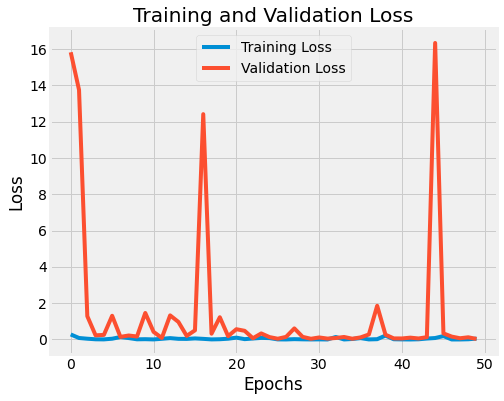

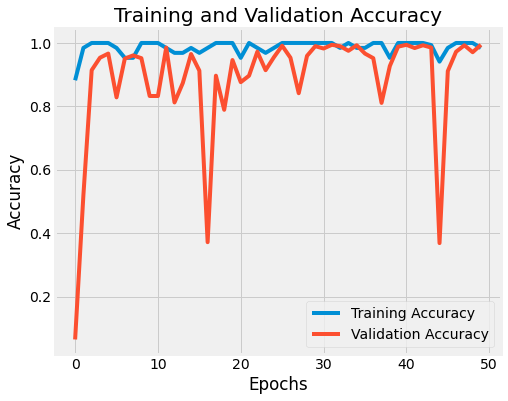

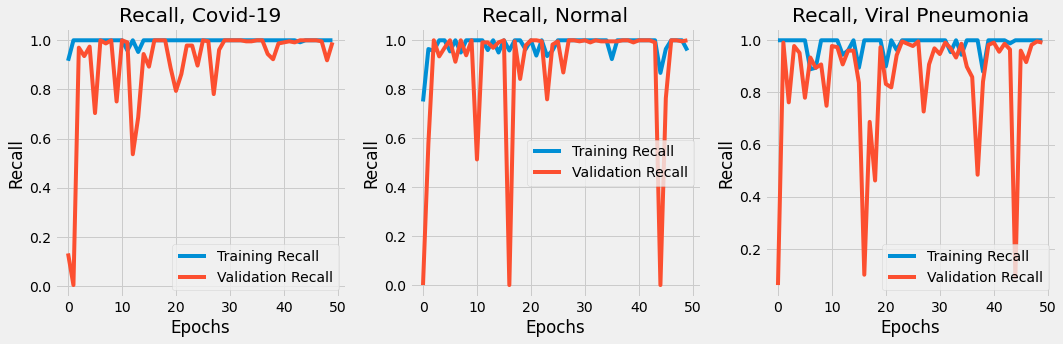

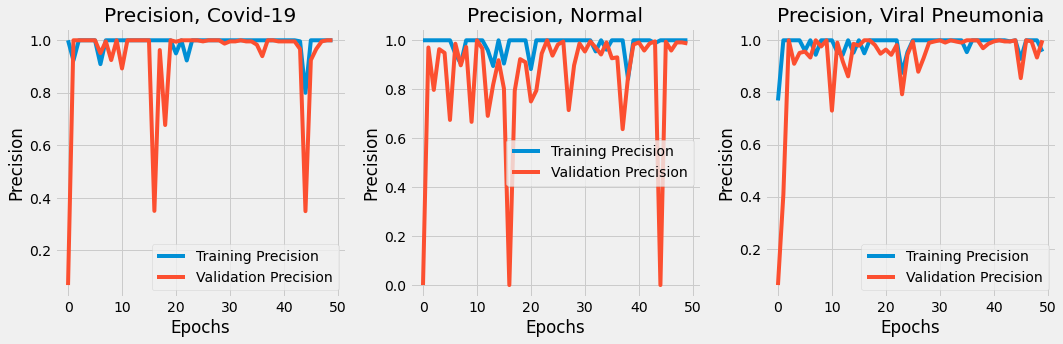

In [ ]:
with open("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/plotting_history.json", 'r') as fs:
  plotting_history = json.load(fs)
plotting_history = history_to_obj(plotting_history)
plot_classification_report(plotting_history, selected_run="1")

### Max Uncertainty

#### Loading the generative model




In [ ]:
from ACCGAN_Uncertainty import ACCGANUnc
from GenerativeClassification import GenerativeClassification

In [ ]:
# LOAD A CHECKPOINT FROM DRIVE
checkpoint_dir = '/content/drive/MyDrive/BIOINF/checkpoints_GAN/AC-cGAN_max_unc' #

generative_model = ACCGANUnc(batch_size=batch_size, use_residual=True) #
checkpoint = tf.train.Checkpoint(generator_optimizer=generative_model.generator_optimizer,
                                    discriminator_optimizer=generative_model.discriminator_optimizer,
                                    model=generative_model.model)

latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
checkpoint.restore(latest)

/content/drive/MyDrive/BIOINF/checkpoints_GAN/AC-cGAN_max_unc/ckpt-11


#### Testing generation capabilities

In [ ]:
# noise used during training in order to evaluate how the network is learning
benchmarkNoise = tf.random.normal([512, generative_model.latent_size])
benchmarkLabels = np.random.randint(0, generative_model.n_classes, 512)

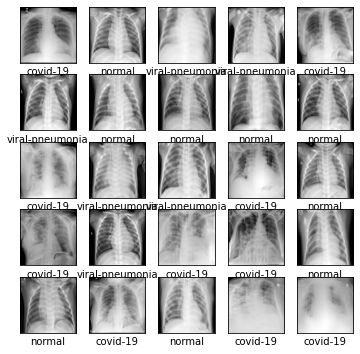

In [ ]:
generative_model.plot_fake_figures(generative_model.generator.predict([benchmarkNoise, benchmarkLabels]), benchmarkLabels, 5, 0)

#### Half data training (early stopping)

In [ ]:
history = train(generative_model, train_ds, val_ds,
                n_trials=5, batch_size=batch_size, half_data=True, patience=10,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data")

In [ ]:
history = history_to_dict(history)
save_history(history, "/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/AC-cGAN_max_unc_half_data")

#### Half Data Training (1 run without early stopping)

In [ ]:
plotting_history = train(generative_model, train_ds, val_ds,
                n_trials=1, batch_size=batch_size, half_data=True, patience=50, max_epochs=50,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/plotting_run")

In [ ]:
plotting_history = history_to_dict(plotting_history)
save_history(plotting_history,"/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/plotting_history")

#### Half data testing

In [ ]:
results = evaluate_model("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/", test_ds)

--------------- TRIAL 1 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/1/best/ckpt-1
6/6 - 4s - loss: 0.1198 - accuracy: 0.9739 - recall_102: 0.9913 - recall_103: 0.9403 - recall_104: 0.9925 - precision_102: 1.0000 - precision_103: 0.9921 - precision_104: 0.9568
--------------- TRIAL 2 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/2/best/ckpt-1
6/6 - 3s - loss: 0.1582 - accuracy: 0.9608 - recall_108: 0.9739 - recall_109: 0.9552 - recall_110: 0.9552 - precision_108: 1.0000 - precision_109: 0.9343 - precision_110: 0.9552
--------------- TRIAL 3 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/3/best/ckpt-1
6/6 - 3s - loss: 0.2592 - accuracy: 0.9504 - recall_114: 0.9826 - recall_115: 0.8881 - recall_116: 0.9851 - precision_114: 1.0000 - precision_115: 0.9835 - precision_116: 0.8859
--------------- TRIAL 4 -

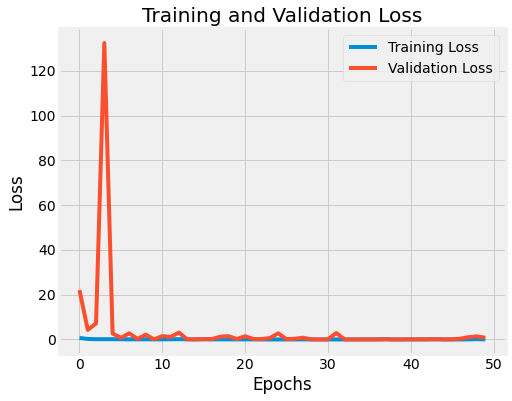

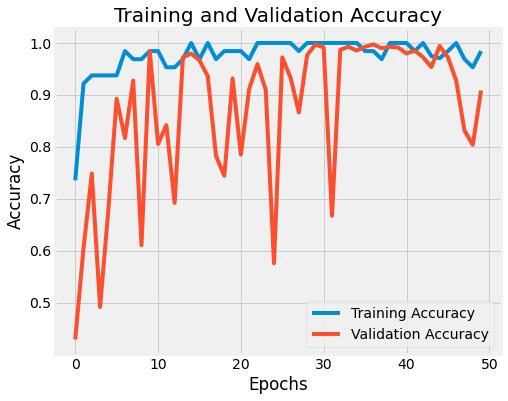

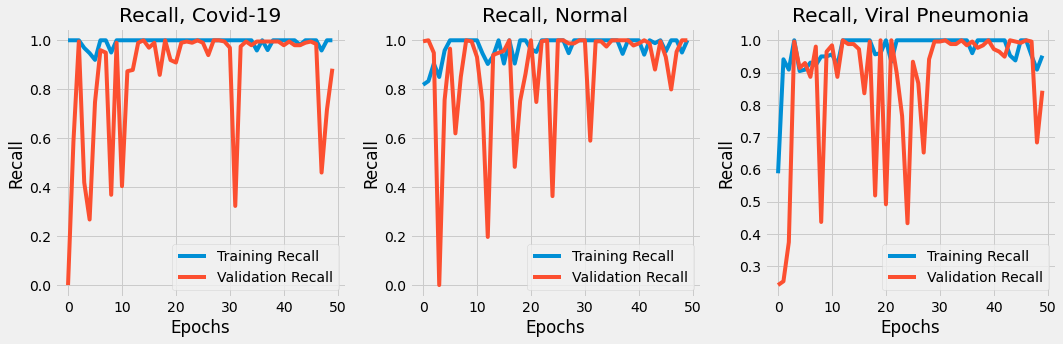

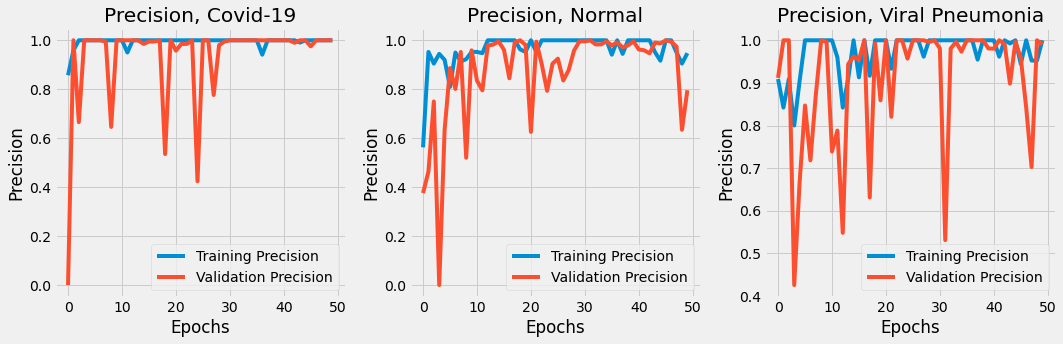

In [ ]:
with open("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/plotting_history.json", 'r') as fs:
  plotting_history = json.load(fs)
plotting_history = history_to_obj(plotting_history)
plot_classification_report(plotting_history, selected_run="1")

### Min Uncertainty

#### Loading the generative model




In [ ]:
from ACCGAN_Uncertainty import ACCGANUnc
from GenerativeClassification import GenerativeClassification

In [ ]:
# LOAD A CHECKPOINT FROM DRIVE
checkpoint_dir = '/content/drive/MyDrive/BIOINF/checkpoints_GAN/AC-CGAN-uncertainty/gilberto/mcd_4_unc_weight_1_disc_min' #

generative_model = ACCGANUnc(batch_size=batch_size, use_residual=True) #
checkpoint = tf.train.Checkpoint(generator_optimizer=generative_model.generator_optimizer,
                                    discriminator_optimizer=generative_model.discriminator_optimizer,
                                    model=generative_model.model)

latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
checkpoint.restore(latest)

/content/drive/MyDrive/BIOINF/checkpoints_GAN/AC-CGAN-uncertainty/gilberto/mcd_4_unc_weight_1_disc_min/ckpt-9


#### Testing generation capabilities

In [ ]:
# noise used during training in order to evaluate how the network is learning
benchmarkNoise = tf.random.normal([512, generative_model.latent_size])
benchmarkLabels = np.random.randint(0, generative_model.n_classes, 512)

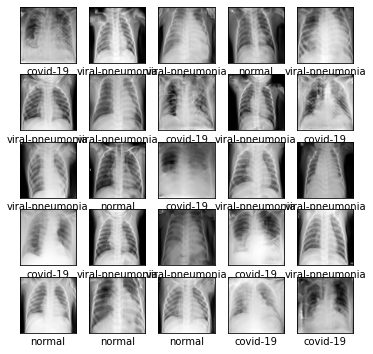

In [ ]:
generative_model.plot_fake_figures(generative_model.generator.predict([benchmarkNoise, benchmarkLabels]), benchmarkLabels, 5, 0)

#### Half data training (early stopping)

In [ ]:
history = train(generative_model, train_ds, val_ds,
                n_trials=5, batch_size=batch_size, half_data=True, patience=10,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data")

In [ ]:
history = history_to_dict(history)
save_history(history, "/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/AC-cGAN_min_unc_half_data")

#### Half Data Training (1 run without early stopping)

In [ ]:
plotting_history = train(generative_model, train_ds, val_ds,
                n_trials=1, batch_size=batch_size, half_data=True, patience=50, max_epochs=50,
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/plotting_run")

In [ ]:
plotting_history = history_to_dict(plotting_history)
save_history(plotting_history,"/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/plotting_history")

#### MCD Training

In [ ]:
# Testing of MCD nets is in the InceptionNetMCD notebook
# If it doesn't work the first time, re execute the cell three times and it works
mcd_history = train(generative_model, train_ds, val_ds,
                n_trials=1, batch_size=batch_size, half_data=True, patience=10, mod_type="inception_mcd",
                checkpoint_dir="/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/mcd_run")

#### Half data testing

In [ ]:
results = evaluate_model("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/", test_ds)

--------------- TRIAL 1 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/1/best/ckpt-1
6/6 - 4s - loss: 0.1080 - accuracy: 0.9582 - recall_180: 1.0000 - recall_181: 0.9254 - recall_182: 0.9552 - precision_180: 0.9914 - precision_181: 0.9612 - precision_182: 0.9275
--------------- TRIAL 2 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/2/best/ckpt-1
6/6 - 3s - loss: 0.2738 - accuracy: 0.9530 - recall_186: 0.9826 - recall_187: 0.9254 - recall_188: 0.9552 - precision_186: 0.9912 - precision_187: 0.9612 - precision_188: 0.9143
--------------- TRIAL 3 --------------- 
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/3/best/ckpt-1
6/6 - 3s - loss: 0.1291 - accuracy: 0.9530 - recall_192: 0.9739 - recall_193: 0.9030 - recall_194: 0.9776 - precision_192: 0.9912 - precision_193: 0.9758 - precision_194: 0.9034
--------------- TRIAL 4 -

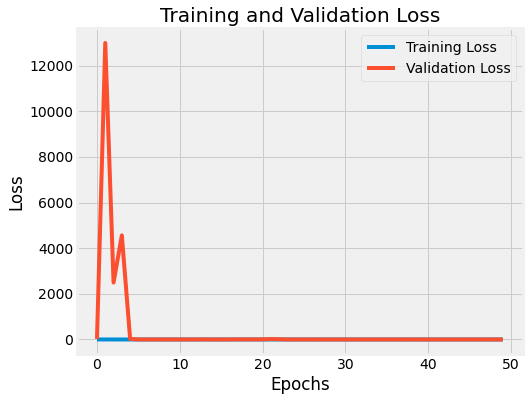

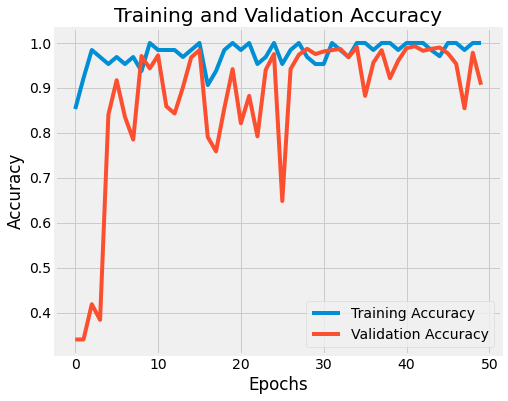

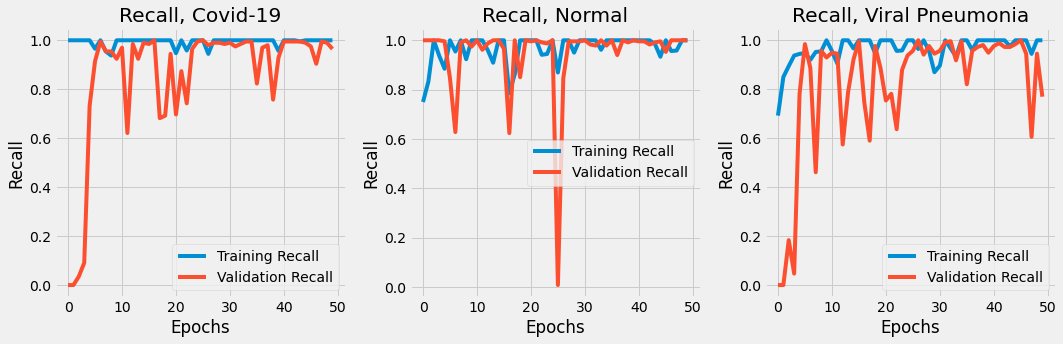

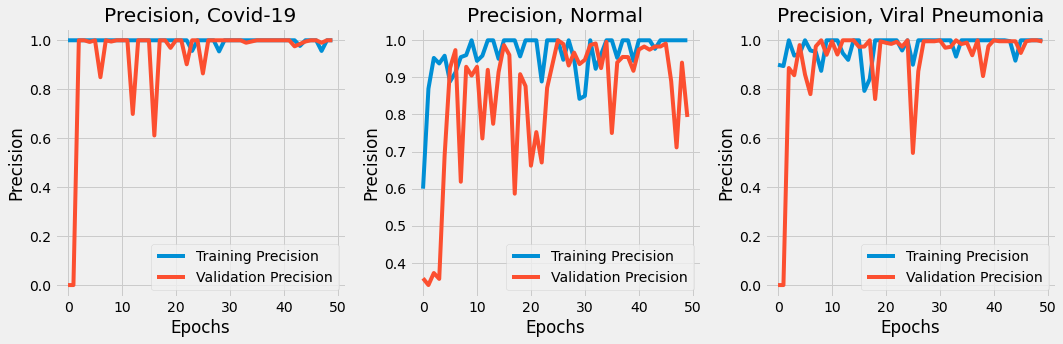

In [ ]:
with open("/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/plotting_history.json", 'r') as fs:
  plotting_history = json.load(fs)
plotting_history = history_to_obj(plotting_history)
plot_classification_report(plotting_history, selected_run="1")